# CTG Analysis for Classification of Fetal Distress

Team Members: Larry Chew and Kayli Leung

## Import Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, roc_curve, auc, roc_auc_score, hamming_loss, log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from model_functions import get_scores, get_auc_scores, plot_roc_curve, show_cm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import numpy as np
np.random.seed(2019)

## Load Dataset

In [2]:
ctg_df = pd.read_excel('CTG.xls', sheet_name='Raw Data')

Drop first row because empty. Drop last three rows because not actually data, just someone's scratch work.

In [3]:
ctg_df = ctg_df.drop(0)
ctg_df = ctg_df[:-3]
ctg_df.head()

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
1,Variab10.txt,1996-12-01,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
2,Fmcs_1.txt,1996-05-03,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,1996-05-03,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,1996-05-03,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
5,Fmcs_1.txt,1996-05-03,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


Reset the index to start at 0.

In [4]:
ctg_df = ctg_df.reset_index()
ctg_df = ctg_df.drop('index', axis=1)

Check for any null values. There are none.

In [5]:
ctg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 40 columns):
FileName    2126 non-null object
Date        2126 non-null datetime64[ns]
SegFile     2126 non-null object
b           2126 non-null float64
e           2126 non-null float64
LBE         2126 non-null float64
LB          2126 non-null float64
AC          2126 non-null float64
FM          2126 non-null float64
UC          2126 non-null float64
ASTV        2126 non-null float64
MSTV        2126 non-null float64
ALTV        2126 non-null float64
MLTV        2126 non-null float64
DL          2126 non-null float64
DS          2126 non-null float64
DP          2126 non-null float64
DR          2126 non-null float64
Width       2126 non-null float64
Min         2126 non-null float64
Max         2126 non-null float64
Nmax        2126 non-null float64
Nzeros      2126 non-null float64
Mode        2126 non-null float64
Mean        2126 non-null float64
Median      2126 non-null float64
Vari

Drop columns that are irrelevant to problem (ex. `FileName`) or are classifications for another problem (`A` through `SUSP`).

In [6]:
ctg_df = ctg_df.drop(['FileName', 'Date', 'SegFile','b','e', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP'], axis=1)
ctg_df.head()

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120.0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,...,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,9.0,2.0
1,132.0,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,...,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,6.0,1.0
2,133.0,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,...,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,6.0,1.0
3,134.0,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,...,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,6.0,1.0
4,132.0,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,...,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,2.0,1.0


Create predictor and label DataFrames.

In [7]:
X = ctg_df.drop(['CLASS', 'NSP'], axis=1)
y = ctg_df['NSP']

Combine labels of 2 and 3 as we would definitely want an expert on hand if suspicious medical activity.

In [8]:
y = y.map({1.0: 0, 2.0:1, 3.0:1})

Look for possible categorical predictors and check for normality.

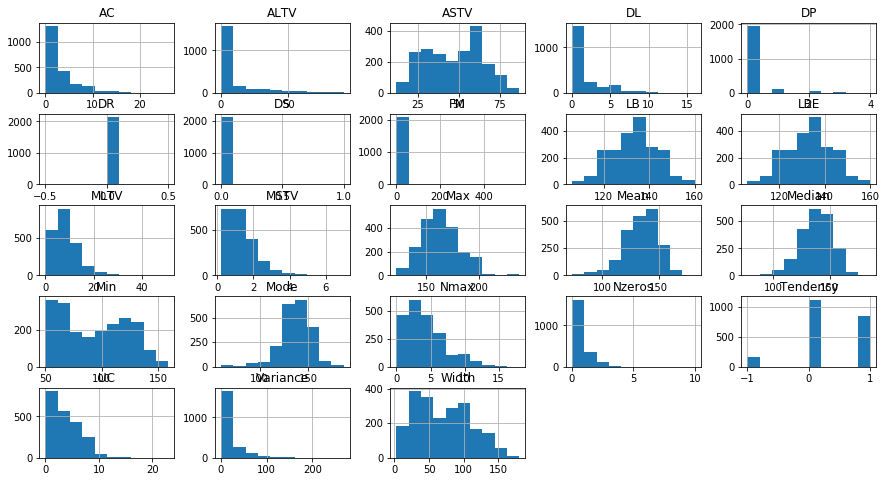

In [9]:
X.hist(figsize=(15, 8));

In [10]:
X['Tendency'].unique()

array([ 1.,  0., -1.])

`Tendency` is categorical so we will OneHotEncode after splitting the data. No other predictor looks to be categorical, however they are not entriely normal and are on different scales. The different scales should not affect tree based models.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

We used pickle files to ensure reproducability.

In [12]:
# pickle.dump(X_train, open('x_train.pkl', 'wb'))
# pickle.dump(X_test, open('x_test.pkl', 'wb'))
# pickle.dump(y_train, open('y_train.pkl', 'wb'))
# pickle.dump(y_test, open('y_test.pkl', 'wb'))

In [13]:
X_train = pickle.load(open('x_train.pkl', 'rb'))
X_test = pickle.load(open('x_test.pkl', 'rb'))
y_train = pickle.load(open('y_train.pkl', 'rb'))
y_test = pickle.load(open('y_test.pkl', 'rb'))

OneHotEncode `Tendency`

In [14]:
mapper = DataFrameMapper(
    [(["Tendency"], OneHotEncoder(categories='auto', drop='first')),]
    , df_out=True)

In [15]:
mapper.fit(X_train)

DataFrameMapper(default=False, df_out=True,
                features=[(['Tendency'],
                           OneHotEncoder(categorical_features=None,
                                         categories='auto', drop='first',
                                         dtype=<class 'numpy.float64'>,
                                         handle_unknown='error', n_values=None,
                                         sparse=True))],
                input_df=False, sparse=False)

In [16]:
train_output = mapper.transform(X_train)
train_output.head()

,Tendency_0,Tendency_1
835,0.0,1.0
1639,1.0,0.0
863,1.0,0.0
1017,1.0,0.0
2007,1.0,0.0


In [17]:
test_output = mapper.transform(X_test)
test_output.head()

,Tendency_0,Tendency_1
68,1.0,0.0
2124,0.0,1.0
387,1.0,0.0
1928,0.0,1.0
2005,1.0,0.0


In [18]:
X_train_full = pd.concat([X_train.drop('Tendency', axis=1), train_output], axis=1)
X_train_full.head()

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency_0,Tendency_1
835,128.0,128.0,3.0,0.0,1.0,16.0,3.3,0.0,3.7,5.0,...,57.0,171.0,6.0,1.0,136.0,130.0,136.0,26.0,0.0,1.0
1639,130.0,130.0,9.0,2.0,3.0,52.0,1.6,0.0,4.2,5.0,...,73.0,179.0,7.0,0.0,144.0,138.0,143.0,29.0,1.0,0.0
863,142.0,142.0,1.0,0.0,5.0,44.0,0.7,40.0,7.1,0.0,...,130.0,158.0,3.0,0.0,147.0,146.0,148.0,0.0,1.0,0.0
1017,139.0,139.0,1.0,0.0,1.0,38.0,1.0,0.0,11.7,0.0,...,114.0,161.0,2.0,0.0,142.0,141.0,142.0,3.0,1.0,0.0
2007,125.0,125.0,1.0,1.0,6.0,63.0,1.2,0.0,0.8,6.0,...,64.0,164.0,8.0,1.0,114.0,114.0,117.0,15.0,1.0,0.0


In [19]:
X_test_full = pd.concat([X_test.drop('Tendency', axis=1), test_output], axis=1)
X_test_full.head()

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency_0,Tendency_1
68,140.0,140.0,5.0,0.0,3.0,34.0,1.2,0.0,10.3,0.0,...,119.0,179.0,2.0,0.0,156.0,153.0,155.0,5.0,1.0,0.0
2124,140.0,140.0,1.0,0.0,9.0,78.0,0.4,27.0,7.0,0.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,0.0,1.0
387,129.0,129.0,4.0,11.0,1.0,37.0,1.2,0.0,8.6,0.0,...,93.0,195.0,8.0,0.0,187.0,157.0,153.0,137.0,1.0,0.0
1928,140.0,140.0,0.0,3.0,5.0,63.0,1.7,5.0,4.0,3.0,...,65.0,148.0,4.0,1.0,140.0,127.0,133.0,32.0,0.0,1.0
2005,125.0,125.0,3.0,1.0,4.0,60.0,1.3,0.0,7.5,6.0,...,68.0,164.0,6.0,1.0,110.0,120.0,120.0,34.0,1.0,0.0


# K-Nearest Neighbors

Our first attempt at a model is KNN. For KNN it is important to scale predictors.

In [20]:
ss = StandardScaler()
scaled_X_train = ss.fit_transform(X_train_full)
scaled_X_test = ss.transform(X_test_full)

We constructed a GridSearch for the best paramaters for a KNN model.

In [21]:
param_grid = {
    'n_neighbors': [5, 3, 10],
    'p': [2, 3, 4],
    'weights':['uniform', 'distance']
} 

knn = KNeighborsClassifier()
gscv = GridSearchCV(knn, param_grid=param_grid, cv=5)
gscv.fit(scaled_X_train, y_train)
best_params = gscv.best_params_
best_params

{'n_neighbors': 5, 'p': 3, 'weights': 'distance'}

In [22]:
knn = KNeighborsClassifier(n_neighbors=5, p=3, weights='distance')
knn.fit(scaled_X_train, y_train)
y_train_hat = knn.predict(scaled_X_train)
y_test_hat = knn.predict(scaled_X_test)

We are interested in recall scores because we want to minimize our false negatives. Since recall measures true positives over actual positves, this is a good metric.

We also measured Hamming-Loss to determine the fraction of incorrect predictions.

In [23]:
get_scores(y_train, y_train_hat, y_test, y_test_hat)

Training Recall: 1.0
Testing Recall: 0.75
Training Hamming-Loss: 0.0
Testing Hamming-Loss: 0.08082706766917293


In [24]:
log_loss(y_test, knn.predict_proba(scaled_X_test)[:,1])

0.6405423158467823

The testing recall is not great because only 75% of the actual positives are classified as such. By further looking at ROC curves and the confusion matrix, we can see that this is likely not the best model.

In [25]:
y_test_score = get_auc_scores(knn, X_train_full, X_test_full, y_train, y_test)

Training AUC: 0.7432982073230342
Testing AUC: 0.7569835875331565


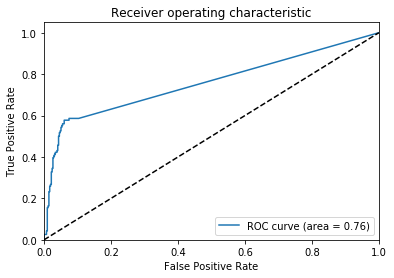

In [26]:
plot_roc_curve(y_test, y_test_score)

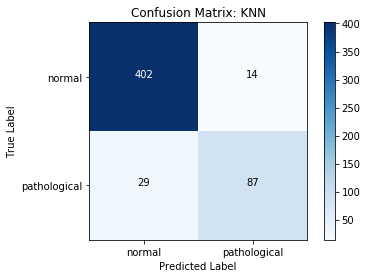

In [27]:
show_cm(y_test, y_test_hat, class_names=('normal', 'pathological'), model_name='KNN')

Probably not the best predictor as we want to minimize false negatives and 25% of the true positives are predicted as negatives.

# Decision Tree

The next classifier model we will try are Decision Trees. First, we will run a simple decision tree with max_depth of 5 for exploration.

In [28]:
dec_tree = DecisionTreeClassifier(max_depth=5)
dec_tree.fit(X_train_full, y_train)
y_train_hat = dec_tree.predict(X_train_full)
y_test_hat = dec_tree.predict(X_test_full)

In [29]:
get_scores(y_train, y_train_hat, y_test, y_test_hat)

Training Recall: 0.8225352112676056
Testing Recall: 0.8103448275862069
Training Hamming-Loss: 0.05081555834378921
Testing Hamming-Loss: 0.06578947368421052


In [30]:
log_loss(y_test, dec_tree.predict_proba(X_test_full)[:,1])

0.4409343029154251

The recall is a bit better than for KNN, but still not great for a medical situation.

In [31]:
y_test_score = get_auc_scores(dec_tree, X_train_full, X_test_full, y_train, y_test)

Training AUC: 0.9558173902170082
Testing AUC: 0.9403804708222812


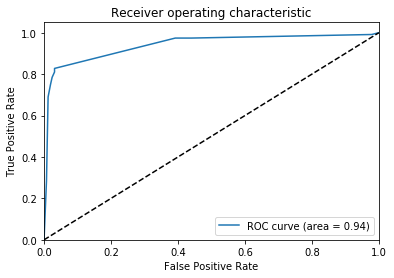

In [32]:
plot_roc_curve(y_test, y_test_score)

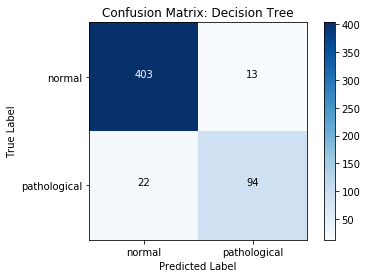

In [33]:
show_cm(y_test, y_test_hat, class_names=('normal', 'pathological'), model_name='Decision Tree')

There is still a large amount of false negatives in this model. We will Grid Search to find better parameters for the Decision Tree.

In [34]:
dt_clf = DecisionTreeClassifier()

param_grid = {
    'max_depth': [3, 5, 8],
    'min_samples_split': [2, 4, 6],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

gs_dt = GridSearchCV(dt_clf, param_grid, cv=5)
gs_dt.fit(X_train_full, y_train)
best_params = gs_dt.best_params_
best_params

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 8,
 'min_samples_split': 4}

In [35]:
dt = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=8, min_samples_split=4)
dt.fit(X_train_full, y_train)

y_train_hat = dt.predict(X_train_full)
y_test_hat = dt.predict(X_test_full)

In [36]:
get_scores(y_train, y_train_hat, y_test, y_test_hat)

Training Recall: 0.9943661971830986
Testing Recall: 0.9482758620689655
Training Hamming-Loss: 0.015683814303638646
Testing Hamming-Loss: 0.05827067669172932


In [37]:
log_loss(y_test, dt.predict_proba(X_test_full)[:,1])

1.10724288171112

The recall score is much improved. And only about 6% of all cases are missclassified.

In [38]:
y_test_score = get_auc_scores(dt, X_train_full, X_test_full, y_train, y_test)

Training AUC: 0.9991974445543317
Testing AUC: 0.9570726956233422


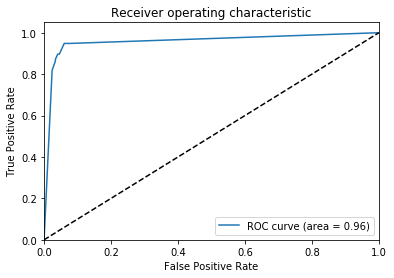

In [39]:
plot_roc_curve(y_test, y_test_score)

The AUC score is nearly 1 and the ROC curve hugs the upper left corner. Both are good indicators that the model is a good predictor of the test set.

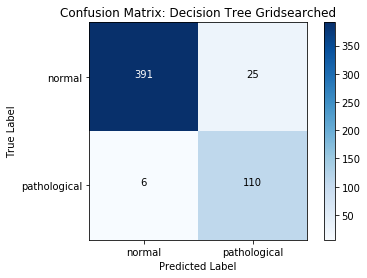

In [40]:
show_cm(y_test, y_test_hat, class_names=('normal', 'pathological'), model_name='Decision Tree Gridsearched')

Only 6 out of 116 of true suspect/pathological cases are missclassified. This is our strongest predictor so far. There is a big number of false positives, but it is better to predict positive rather than negative in this situation.

# PCA

We wanted to see if reducing dimensionality had any impact on the classification of a decision tree. We found the recall was much worse, so we abandonned further exploration.

In [41]:
pca = PCA(n_components=3)
pca.fit(X_train_full)
principal_comps = pca.transform(X_train_full)
pca.components_

array([[-5.24361304e-02, -5.24361304e-02,  1.41305432e-02,
         1.92137617e-01,  9.08276962e-03, -9.89688046e-02,
         1.15448146e-02, -1.62117966e-01,  6.46531479e-03,
         2.68525698e-02,  8.25388576e-05,  3.20951958e-03,
         0.00000000e+00,  6.70981137e-01, -4.87917795e-01,
         1.83063342e-01,  3.84444564e-02,  4.05923057e-03,
        -1.06607662e-01, -1.33649313e-01, -9.80011261e-02,
         3.97742013e-01, -1.21479880e-03,  7.21633046e-04],
       [ 2.50597562e-02,  2.50597562e-02, -7.04004668e-04,
         9.79458469e-01, -9.18829249e-03, -1.52028464e-02,
        -2.14777674e-03,  4.44552870e-02,  1.24748990e-03,
        -9.59877698e-03, -6.57547066e-05,  8.01322369e-04,
        -0.00000000e+00, -1.31213798e-01,  1.09206669e-01,
        -2.20071291e-02, -2.21118555e-03, -2.38657021e-03,
         4.23196344e-02,  4.11451581e-02,  3.46166366e-02,
        -5.18981246e-02,  3.87526219e-04, -2.10438663e-04],
       [-2.54598438e-01, -2.54598438e-01, -4.04567987e

In [42]:
comps = pd.DataFrame(principal_comps, columns=['PC1', 'PC2', 'PC3'])
principal_comps_test = pca.transform(X_test_full)

In [43]:
dt_pca = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8, min_samples_split=6)
dt_pca.fit(principal_comps, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [44]:
y_test_hat = dt_pca.predict(principal_comps_test)
y_train_hat = dt_pca.predict(principal_comps)

In [45]:
get_scores(y_train, y_train_hat, y_test, y_test_hat)

Training Recall: 0.7633802816901408
Testing Recall: 0.6120689655172413
Training Hamming-Loss: 0.07716436637390213
Testing Hamming-Loss: 0.15601503759398497


# Random Forest

After making a single decision tree, we wanted to model a random forest. We again started with a generic model and then grid searched to find a better model.

In [46]:
rf = RandomForestClassifier(n_estimators=5)

In [47]:
rf.fit(X_train_full, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [48]:
y_train_hat = rf.predict(X_train_full)
y_test_hat = rf.predict(X_test_full)

In [49]:
get_scores(y_train, y_train_hat, y_test, y_test_hat)

Training Recall: 0.9690140845070423
Testing Recall: 0.8017241379310345
Training Hamming-Loss: 0.00878293601003764
Testing Hamming-Loss: 0.06203007518796992


In [50]:
log_loss(y_test, rf.predict_proba(X_test_full)[:,1])

0.5720036271550952

In [51]:
y_test_score = get_auc_scores(rf, X_train_full, X_test_full, y_train, y_test)

Training AUC: 0.9996078163898646
Testing AUC: 0.9546066810344829


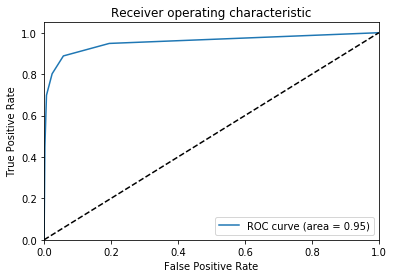

In [52]:
plot_roc_curve(y_test, y_test_score)

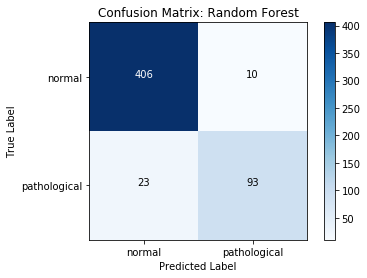

In [53]:
show_cm(y_test, y_test_hat, class_names=('normal', 'pathological'), model_name='Random Forest')

This random forest was a worse predictor than our grid searched decision tree.

In [54]:
param_grid = {
    'n_estimators':[3, 5, 7, 9],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 8],
    'min_samples_split': [2, 4, 6, 8],
    'class_weight': [None, 'balanced']
}

rf_clf = RandomForestClassifier()
gs_rf = GridSearchCV(rf_clf, param_grid=param_grid, cv=5)
gs_rf.fit(X_train, y_train)

best_params = gs_rf.best_params_
best_params

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_split': 4,
 'n_estimators': 9}

In [55]:
rf = RandomForestClassifier(class_weight=None, criterion='entropy',
                            max_depth=8, min_samples_split=4, n_estimators=9)

In [56]:
rf.fit(X_train_full, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [57]:
y_train_hat = rf.predict(X_train_full)
y_test_hat = rf.predict(X_test_full)

In [58]:
get_scores(y_train, y_train_hat, y_test, y_test_hat)

Training Recall: 0.9464788732394366
Testing Recall: 0.8103448275862069
Training Hamming-Loss: 0.013174404015056462
Testing Hamming-Loss: 0.05639097744360902


In [59]:
log_loss(y_test, rf.predict_proba(X_test_full)[:,1])

0.14223373123234268

In [60]:
y_test_score = get_auc_scores(rf, X_train_full, X_test_full, y_train, y_test)

Training AUC: 0.9989916902545215
Testing AUC: 0.9852557194960213


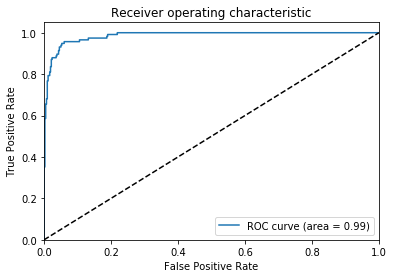

In [61]:
plot_roc_curve(y_test, y_test_score)

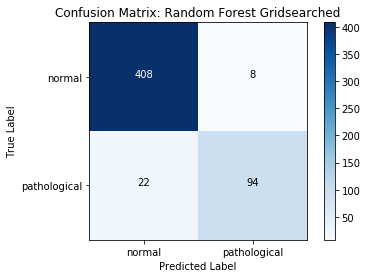

In [62]:
show_cm(y_test, y_test_hat, class_names=('normal', 'pathological'), model_name='Random Forest Gridsearched')

While the AUC score was better, the confusion matrix shows a high number of false negatives.

# XGBoost

We add another layer of randomness to random forest by using XGBoost.

In [63]:
boosted = xgb.XGBClassifier()
boosted.fit(X_train_full, y_train)

y_train_hat = boosted.predict(X_train_full)
y_test_hat = boosted.predict(X_test_full)

In [64]:
get_scores(y_train, y_train_hat, y_test, y_test_hat)

Training Recall: 0.9352112676056338
Testing Recall: 0.853448275862069
Training Hamming-Loss: 0.018820577164366373
Testing Hamming-Loss: 0.05263157894736842


In [65]:
log_loss(y_test, boosted.predict_proba(X_test_full)[:,1])

0.1230133362492998

In [66]:
y_test_score = get_auc_scores(boosted, X_train_full, X_test_full, y_train, y_test)

Training AUC: 0.9979424570018984
Testing AUC: 0.9880843832891247


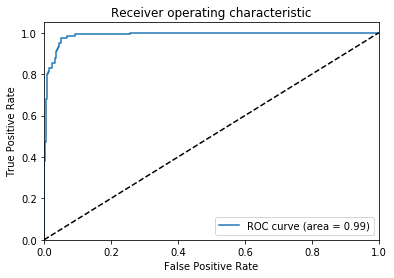

In [67]:
plot_roc_curve(y_test, y_test_score)

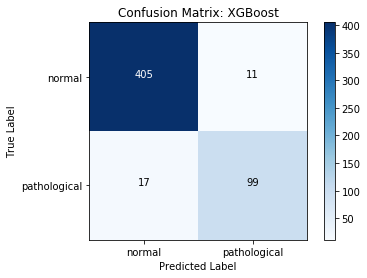

In [68]:
show_cm(y_test, y_test_hat, class_names=('normal', 'pathological'), model_name='XGBoost')

Still a large number of false negatives than the optimized decision tree. We then grid search the XGBoost classififer.

In [69]:
param_grid = {
    'learning_rate': [.1, .01, .5, 1],
    'max_depth': [3, 5, 8],
    'n_estimators': [10, 100, 1000],    
}
gs_xgb = GridSearchCV(xgb.XGBClassifier(), param_grid=param_grid, cv=5)
gs_xgb.fit(X_train_full, y_train)
best_params = gs_xgb.best_params_
best_params

{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1000}

In [70]:
boost_clf = xgb.XGBClassifier(learning_rate=0.01, max_depth=8, n_estimators=1000)
boost_clf.fit(X_train_full, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [71]:
y_train_hat = boost_clf.predict(X_train_full)
y_test_hat = boost_clf.predict(X_test_full)

In [72]:
get_scores(y_train, y_train_hat, y_test, y_test_hat)

Training Recall: 1.0
Testing Recall: 0.9396551724137931
Training Hamming-Loss: 0.0
Testing Hamming-Loss: 0.03195488721804511


In [73]:
log_loss(y_test, boost_clf.predict_proba(X_test_full)[:,1])

0.10513574839088212

In [74]:
y_test_score = get_auc_scores(boost_clf, X_train_full, X_test_full, y_train, y_test)

Training AUC: 1.0
Testing AUC: 0.9873383620689655


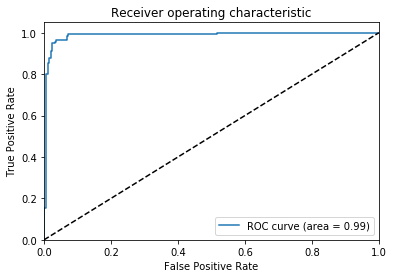

In [75]:
plot_roc_curve(y_test, y_test_score)

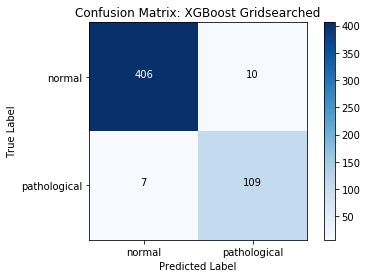

In [76]:
show_cm(y_test, y_test_hat, class_names=('normal', 'pathological'), model_name='XGBoost Gridsearched')

While the recall value is a little low at 94%, we can see that the false negative rate is about 6% and the false positve rate is about 2.4%. While the decision tree was a slightly better predictor for pathological cases, we also don't want to have as many false positives as the decision tree. We therefore stick to using the XGBoosted classifier model.

In [77]:
boost_clf.feature_importances_

array([0.06209674, 0.        , 0.05356602, 0.0519205 , 0.05711687,
       0.10314814, 0.01926991, 0.09466072, 0.06954488, 0.01021955,
       0.        , 0.04668081, 0.        , 0.03650457, 0.05373923,
       0.04785   , 0.0355952 , 0.00944009, 0.08080371, 0.06880873,
       0.03191443, 0.05417226, 0.00489326, 0.00805439], dtype=float32)

In [78]:
X_train_full.columns

Index(['LBE', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL',
       'DS', 'DP', 'DR', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode',
       'Mean', 'Median', 'Variance', 'Tendency_0', 'Tendency_1'],
      dtype='object')

<BarContainer object of 24 artists>

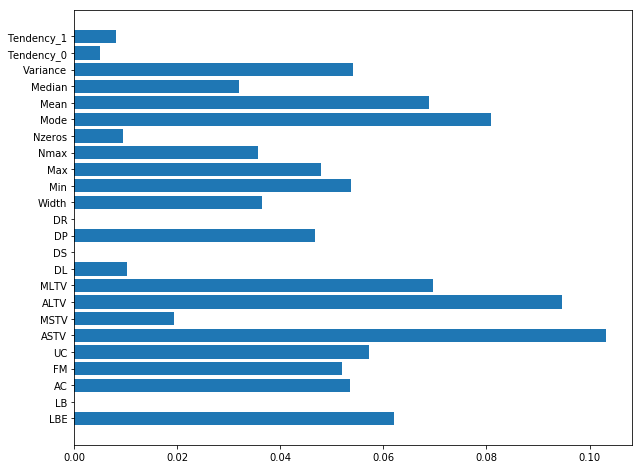

In [79]:
plt.figure(figsize=(10,8))
plt.barh(X_train_full.columns, boost_clf.feature_importances_)

Looking at the feature importance of our model, we can see that percentage of time for abnormal short and long term variability are used a lot in the model to make splits. On the other hand, the SisPorto Baseline in addition to severe and repetitive decelerations were not used often or at all in decisions to make splits.